## Intial Setup

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Load Dataset

In [11]:
# import pathlib

# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
# data_dir = pathlib.Path(data_dir).with_suffix('')

In [12]:
import pathlib

# Directly specify the local path to the dataset
data_dir = "D:\Purwadhika\Folder_1\module_3\porti\ImageClassification\\flower_photos"

# Convert the string path to a Path object
data_dir = pathlib.Path(data_dir)

# You can now use data_dir to load and work with your data


In [13]:
print(data_dir)

D:\Purwadhika\Folder_1\module_3\porti\ImageClassification\flower_photos


In [14]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


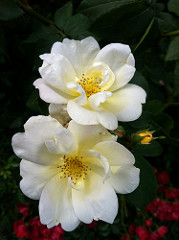

In [15]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

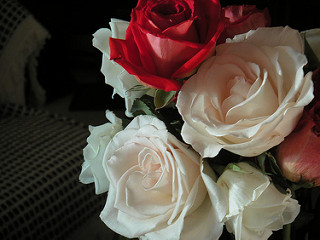

In [16]:
PIL.Image.open(str(roses[1]))

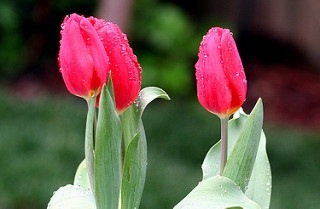

In [17]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

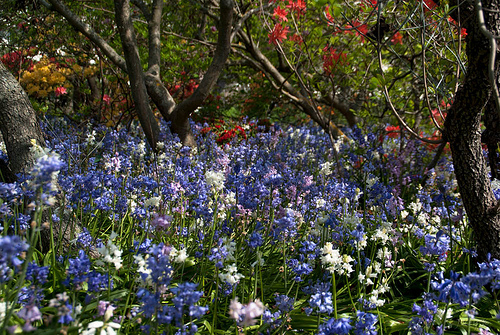

In [18]:
PIL.Image.open(str(tulips[1]))

## Load dataset using a Keras utility

### Create a dataset

In [19]:
batch_size = 32
img_height = 180
img_width = 180

In [20]:
# Set up a dataset pipeline to load images from a directory
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,                                 # The directory where images are stored
  validation_split=0.2,                     # Split 20% of data for validation
  subset="training",                        # Specify this subset is for training
  seed=123,                                 # Seed for reproducibility
  image_size=(img_height, img_width),       # Resize images to 180x180 pixels
  batch_size=batch_size)                    # Load data in batches of 32 images

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
train_ds

In [21]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,                                 # The directory where images are stored
  validation_split=0.2,                     # Split 20% of data for validation
  subset="validation",                      # Specify this subset is for validation
  seed=123,                                 # Seed for reproducibility
  image_size=(img_height, img_width),       # Resize images to 180x180 pixels
  batch_size=batch_size)                    # Load data in batches of 32 images                    

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [48]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [22]:
# dataset attributes
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Data visualization

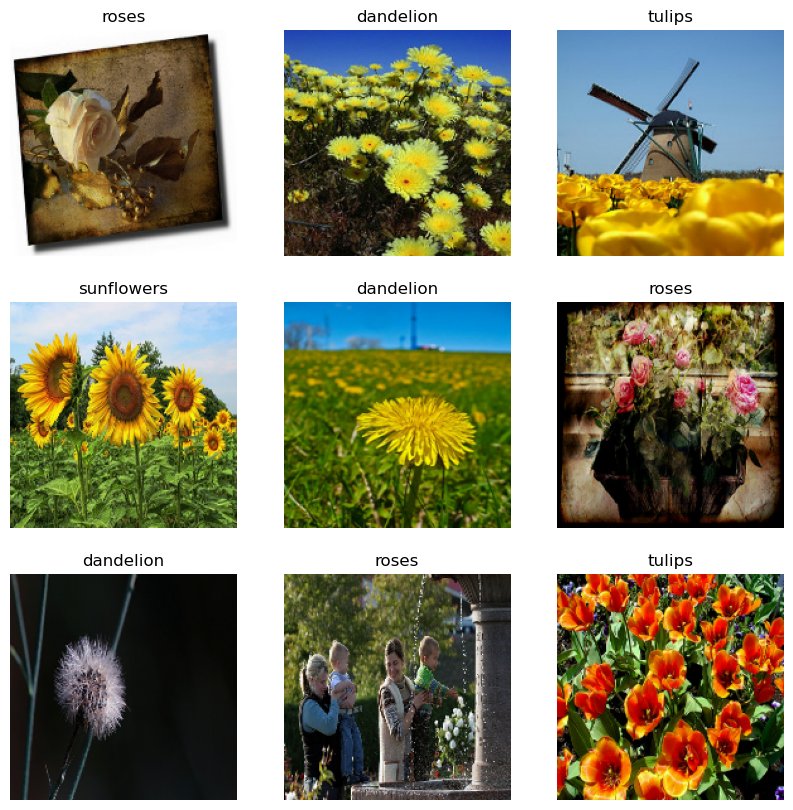

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data Standarization

In [26]:
normalization_layer = layers.Rescaling(1./255)

In [27]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9994038


## Create the model

The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [28]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

c:\Users\Dafa\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Compile the model

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Summary

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [31]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.3244 - loss: 1.6279 - val_accuracy: 0.5831 - val_loss: 1.1005
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.6152 - loss: 1.0120 - val_accuracy: 0.6172 - val_loss: 0.9478
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.7076 - loss: 0.8019 - val_accuracy: 0.6172 - val_loss: 0.9526
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.7727 - loss: 0.5939 - val_accuracy: 0.6417 - val_loss: 1.0085
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.8810 - loss: 0.3811 - val_accuracy: 0.6213 - val_loss: 1.1580
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0.9188 - loss: 0.2539 - val_accuracy: 0.6390 - val_loss: 1.3100
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.9696 - loss: 0.1103 - val_accuracy: 0.6104 - val_loss: 1.4146
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.9802 - loss: 0.0797 - val_accu

terdapat gejela overfitting, accuracy > val_accuracy

## Vizualize the results

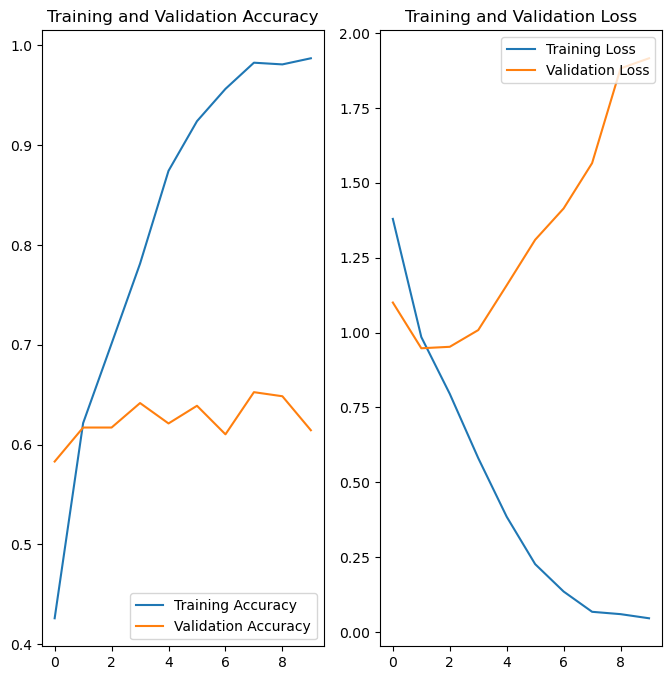

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting

### Data augmentation

In [33]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

c:\Users\Dafa\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


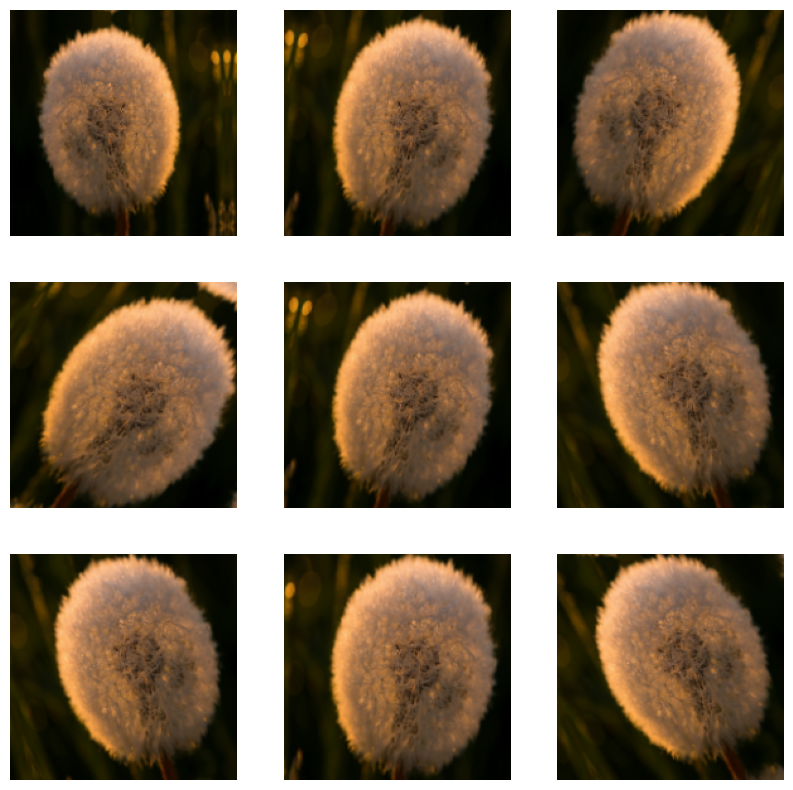

In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

In [35]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.3357 - loss: 1.5583 - val_accuracy: 0.5436 - val_loss: 1.1390
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - accuracy: 0.5476 - loss: 1.1068 - val_accuracy: 0.5695 - val_loss: 1.0509
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - accuracy: 0.5845 - loss: 1.0216 - val_accuracy: 0.6063 - val_loss: 0.9196
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - accuracy: 0.6314 - loss: 0.9040 - val_accuracy: 0.6308 - val_loss: 0.9473
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - accuracy: 0.6590 - loss: 0.8760 - val_accuracy: 0.5899 - val_loss: 1.1348
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - accuracy: 0.6581 - loss: 0.8588 - val_accuracy: 0.6635 - val_loss: 0.8631
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - accuracy: 0.7057 - loss: 0.7691 - val_accuracy: 0.6662 - val_loss: 0.8581
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - accuracy: 0.7104 - loss: 0.7482 - val_accu

## Visualize training results

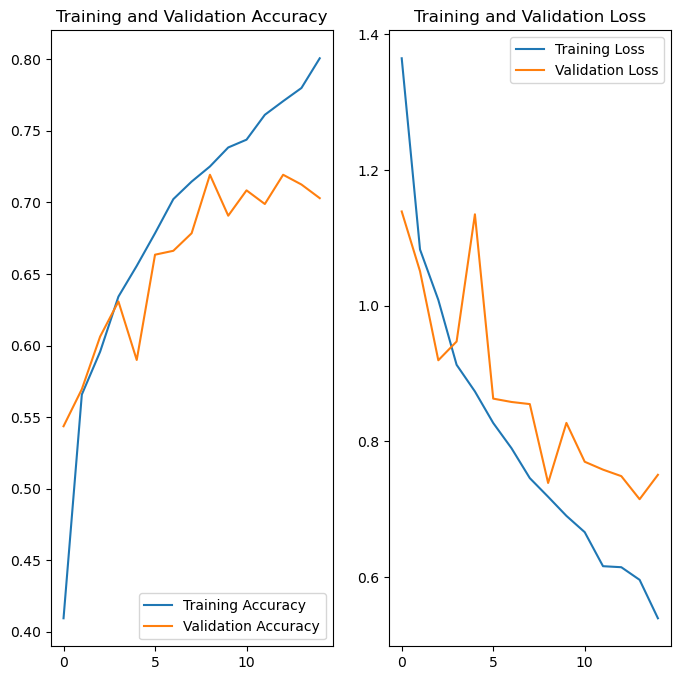

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save model

In [40]:
# model.save(r'D:\Purwadhika\Folder_1\module_3\porti\ImageClassification\save_model\model_bunga.h5')


In [41]:
# model.save(r'D:\Purwadhika\Folder_1\module_3\porti\ImageClassification\save_model\model_bungaa.keras', save_format='keras')


In [42]:
# import pickle

# with open(r'D:\Purwadhika\Folder_1\module_3\porti\ImageClassification\model\model_bunga.sav', 'wb') as f:
#     pickle.dump(model, f)


## Predict to new data

In [43]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
This image most likely belongs to sunflowers with a 90.55 percent confidence.


In [44]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


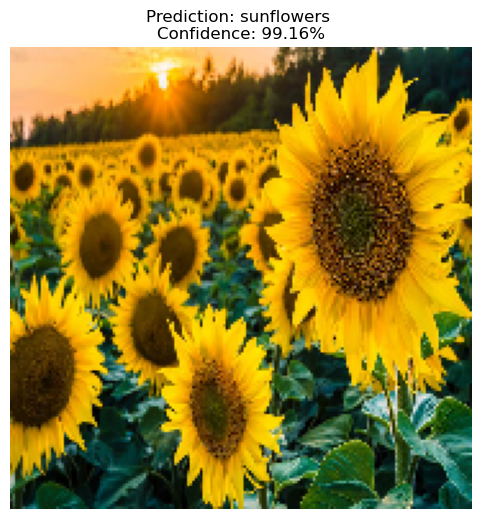

In [45]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Path gambar yang sudah ada di disk
image_path = "black-oil-sunflower.jpg"  #Ganti dengan path gambar yang ada di disk

# Load dan preprocess gambar
img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)  # Resize sesuai dengan ukuran input model
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Buat batch

# Prediksi
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Tampilkan gambar dan hasil prediksi
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')  # Tidak menampilkan axis
plt.title(
    "Prediction: {} \nConfidence: {:.2f}%".format(
        class_names[np.argmax(score)], 100 * np.max(score)
    )
)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


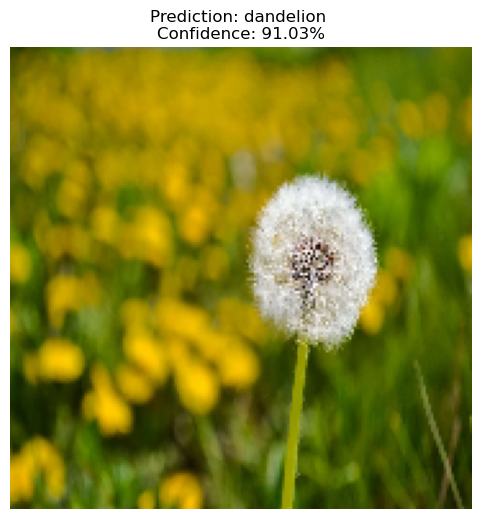

In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Path gambar yang sudah ada di disk
image_path = "dandelion2.jpg"  #Ganti dengan path gambar yang ada di disk

# Load dan preprocess gambar
img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)  # Resize sesuai dengan ukuran input model
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Buat batch

# Prediksi
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Tampilkan gambar dan hasil prediksi
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')  # Tidak menampilkan axis
plt.title(
    "Prediction: {} \nConfidence: {:.2f}%".format(
        class_names[np.argmax(score)], 100 * np.max(score)
    )
)
plt.show()
